# Soft Actor-Critic (SAC) for BipedalWalker-v3

This notebook implements a Soft Actor-Critic (SAC) agent to solve the BipedalWalker-v3 environment from Gymnasium.
SAC is an off-policy actor-critic deep RL algorithm based on the maximum entropy reinforcement learning framework.

In [1]:
# !pip install swig
# !pip install gymnasium[box2d]

import gymnasium as gym
import numpy as np
import cv2  # Added for parallel window rendering
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
from collections import deque
import random
import os
import matplotlib.pyplot as plt
# Change to standard tqdm to avoid notebook widget errors
from tqdm import tqdm

In [2]:
# For local training on Mac, 
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    try:
        torch.cuda.set_device(0)
        gpu_name = torch.cuda.get_device_name(0)
        props = torch.cuda.get_device_properties(0)
        print(f"CUDA GPU: {gpu_name} | Memory: {props.total_memory/1024**3:.1f} GB")
    except Exception as e:
        print(f"GPU info not available: {e}")

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True

set_seed(42)

Using device: mps


## Replay Buffer

The replay buffer stores experience tuples (state, action, reward, next_state, done) to be sampled during training.

In [3]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, buffer_size=int(1e6)):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.size = 0
        
        self.state = np.zeros((buffer_size, state_dim), dtype=np.float32)
        self.action = np.zeros((buffer_size, action_dim), dtype=np.float32)
        self.reward = np.zeros((buffer_size, 1), dtype=np.float32)
        self.next_state = np.zeros((buffer_size, state_dim), dtype=np.float32)
        self.done = np.zeros((buffer_size, 1), dtype=np.float32)
    
    def add(self, state, action, reward, next_state, done):
        # Check if input is batch or single
        if state.ndim == 1:
            state = state[None, :]
            action = action[None, :]
            reward = np.array(reward)[None]
            next_state = next_state[None, :]
            done = np.array(done)[None]
        
        batch_size = len(state)
        
        if self.ptr + batch_size <= self.buffer_size:
            self.state[self.ptr:self.ptr+batch_size] = state
            self.action[self.ptr:self.ptr+batch_size] = action
            self.reward[self.ptr:self.ptr+batch_size] = reward.reshape(-1, 1)
            self.next_state[self.ptr:self.ptr+batch_size] = next_state
            self.done[self.ptr:self.ptr+batch_size] = done.reshape(-1, 1)
            self.ptr = (self.ptr + batch_size) % self.buffer_size
        else:
            # Handle wrap around
            overflow = (self.ptr + batch_size) - self.buffer_size
            split = batch_size - overflow
            
            # First part
            self.state[self.ptr:] = state[:split]
            self.action[self.ptr:] = action[:split]
            self.reward[self.ptr:] = reward[:split].reshape(-1, 1)
            self.next_state[self.ptr:] = next_state[:split]
            self.done[self.ptr:] = done[:split].reshape(-1, 1)
            
            # Second part (overflow)
            self.state[:overflow] = state[split:]
            self.action[:overflow] = action[split:]
            self.reward[:overflow] = reward[split:].reshape(-1, 1)
            self.next_state[:overflow] = next_state[split:]
            self.done[:overflow] = done[split:].reshape(-1, 1)
            self.ptr = overflow
            
        self.size = min(self.size + batch_size, self.buffer_size)
    
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            self.state[ind],
            self.action[ind],
            self.reward[ind],
            self.next_state[ind],
            self.done[ind]
        )
    
    def __len__(self):
        return self.size

## Network Architectures

We define the Actor and Critic networks. The Actor outputs the mean and log standard deviation of the action distribution. The Critic estimates the Q-value for a given state-action pair.

In [4]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim) * 0.1)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mu = self.mu(x)
        return mu, self.log_std
    
    def sample(self, state):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        x_t = dist.rsample()
        action = torch.tanh(x_t)
        
        # Log prob calculation
        log_prob = dist.log_prob(x_t)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(-1, keepdim=True)
        return action, log_prob

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(CriticNetwork, self).__init__()
        # Critic takes state and action as input
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q_value = nn.Linear(hidden_dim, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.q_value(x)

## SAC Agent

The SAC agent orchestrates the interaction with the environment and the training process. It maintains the actor, two critics (for double Q-learning), and their target networks.

In [5]:
class SACAgent:
    def __init__(self, state_dim, action_dim, action_scale=1.0, device="cpu", learning_rate=3e-4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_scale = action_scale
        self.device = device
        self.learning_rate = learning_rate
        
        # Hyperparameters
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = 0.2
        self.batch_size = 256
        self.buffer_size = int(1e6)
        # Automatic entropy tuning target: -dim(A)
        self.target_entropy = -float(action_dim)
        
        # Networks
        self.actor = ActorNetwork(state_dim, action_dim).to(self.device)
        self.critic1 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.critic2 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.target_critic1 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.target_critic2 = CriticNetwork(state_dim, action_dim).to(self.device)
        
        # Copy weights to target networks
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.learning_rate)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=self.learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=self.learning_rate)
        
        # Replay buffer (Now using optimized Numpy buffer with batch support)
        self.replay_buffer = ReplayBuffer(state_dim, action_dim, self.buffer_size)
        
        # Log alpha for entropy adjustment
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=self.learning_rate)
        
    def select_action(self, state, deterministic=False):
        with torch.no_grad():
            if state.ndim == 1:
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            else:
                state = torch.FloatTensor(state).to(self.device)
                
            if deterministic:
                mu, _ = self.actor(state)
                action = torch.tanh(mu)
                return action.cpu().numpy() # Return batch if input was batch
            
            action, _ = self.actor.sample(state)
            return action.cpu().numpy()
    
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
            
        # Sample from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Update critic
        with torch.no_grad():
            next_actions, next_log_pi = self.actor.sample(next_states)
            next_q1 = self.target_critic1(next_states, next_actions)
            next_q2 = self.target_critic2(next_states, next_actions)
            next_q = torch.min(next_q1, next_q2) - self.alpha * next_log_pi
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        current_q1 = self.critic1(states, actions)
        current_q2 = self.critic2(states, actions)
        
        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Update actor
        actions_pred, log_pi = self.actor.sample(states)
        q1 = self.critic1(states, actions_pred)
        q2 = self.critic2(states, actions_pred)
        q = torch.min(q1, q2)
        
        actor_loss = (self.alpha * log_pi - q).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Failsafe for target_entropy
        if not hasattr(self, 'target_entropy'):
            self.target_entropy = -float(self.action_dim)
            
        # Update alpha
        alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()
        
        # Update target networks
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

## Training Loop

We train the agent in the environment. We'll also log rewards and save checkpoints.

In [ ]:
import functools
import logging
import sys
from datetime import datetime

# Define a custom handler to work with tqdm
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.write(msg)
            self.flush()
        except Exception:
            self.handleError(record)

def setup_logger(log_dir="logs"):
    os.makedirs(log_dir, exist_ok=True)
    logger = logging.getLogger("BipedalWalker")
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to avoid duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()
        
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(log_dir, f"training_{timestamp}.log")
    
    # File handler
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    
    # Console handler using TqdmLoggingHandler
    ch = TqdmLoggingHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

class AlternatingLegsRewardWrapper(gym.Wrapper):
    def __init__(self, env, scale=1.0):
        super().__init__(env)
        self.scale = scale
        
    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        
        # BipedalWalker-v3 Observation Space indices:
        # 4: hip_joint_1_angle
        # 5: hip_joint_1_speed
        # 9: hip_joint_2_angle
        # 10: hip_joint_2_speed
        
        hip1_speed = state[5]
        hip2_speed = state[10]
        
        # Reward for moving hips in opposite directions
        alternating_reward = - (hip1_speed * hip2_speed)
        
        # Add to total reward
        reward += alternating_reward * self.scale
        
        return state, reward, done, truncated, info

def save_checkpoint(agent, episode, learning_rate, log_dir="logs", filename=None):
    if filename is None:
        filename = f"checkpoint_ep{episode}.pth"
    
    path = os.path.join(log_dir, filename)
    torch.save({
        'actor_state_dict': agent.actor.state_dict(),
        'critic1_state_dict': agent.critic1.state_dict(),
        'critic2_state_dict': agent.critic2.state_dict(),
        'episode': episode,
        'learning_rate': learning_rate
    }, path)
    return path

def train_agent(env_name="BipedalWalker-v3", max_episodes=1000, max_steps=1000, device="cpu", render=False, learning_rate=3e-4, updates_per_step=1, start_steps=10000, num_envs=1, alternating_legs_scale=5.0, save_interval=10, log_dir=None):
    # Determine log directory
    if log_dir is None:
        log_dir = os.path.join("logs", datetime.now().strftime("run_%Y%m%d_%H%M%S"))

    # Setup logger
    logger = setup_logger(log_dir=log_dir)
    logger.info(f"Starting training with device: {device}, LR: {learning_rate}, Num Envs: {num_envs}")
    logger.info(f"Logs and checkpoints will be saved to: {log_dir}")
    
    # Determine render mode
    render_mode = "rgb_array" if render else None
    
    # Track per-environment progress
    env_step_counts = np.zeros(num_envs, dtype=int)
    env_episode_counts = np.zeros(num_envs, dtype=int)
    
    # Create environment
    if num_envs > 1:
        wrapper_cls = functools.partial(AlternatingLegsRewardWrapper, scale=alternating_legs_scale)
        vec_mode = "sync" if render else "async"
        env = gym.make_vec(env_name, num_envs=num_envs, vectorization_mode=vec_mode, wrappers=[wrapper_cls], render_mode=render_mode)
        logger.info(f"Using {num_envs} vectorized environments ({vec_mode}) with AlternatingLegsRewardWrapper (scale={alternating_legs_scale})")
    else:
        env = gym.make(env_name, render_mode=render_mode)
        env = AlternatingLegsRewardWrapper(env, scale=alternating_legs_scale)
        logger.info(f"Using AlternatingLegsRewardWrapper with scale={alternating_legs_scale}")
        
    if num_envs > 1:
        state_dim = env.single_observation_space.shape[0]
        action_dim = env.single_action_space.shape[0]
        action_scale = float(env.single_action_space.high[0])
    else:
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        action_scale = float(env.action_space.high[0])
    
    # Initialize agent
    logger.info(f"Initializing SAC Agent on device: {device}")
    agent = SACAgent(state_dim, action_dim, action_scale, device=device, learning_rate=learning_rate)
    
    # Training loop
    total_steps = 0
    episode_rewards = []
    
    # Create logs directory if it doesn't exist
    os.makedirs(log_dir, exist_ok=True)
    
    # Progress bar
    pbar = tqdm(range(max_episodes), desc=f"Training Progress", unit="ep")
    
    current_episode = 0
    
    # Reset env
    state, _ = env.reset()
    
    try:
        while current_episode < max_episodes:
            episode_reward = 0 
            if num_envs > 1:
                current_rewards = np.zeros(num_envs)
                
            for step in range(max_steps):
                # Select action
                if total_steps < start_steps:
                    action = env.action_space.sample()
                else:
                    if num_envs > 1:
                        action = agent.select_action(state, deterministic=False) 
                    else:
                        action = agent.select_action(state)
                
                # Take step
                next_state, reward, done, truncated, info = env.step(action)
                
                # Rendering logic
                if render:
                    frames = env.render()
                    
                    # Update counters
                    for i in range(num_envs):
                        if num_envs > 1:
                            is_done = done[i] or truncated[i]
                        else:
                            is_done = done or truncated
                        
                        if is_done:
                            env_episode_counts[i] += 1
                            env_step_counts[i] = 0
                        else:
                            env_step_counts[i] += 1
                            
                    # Display frames
                    if isinstance(frames, (tuple, list)) and len(frames) == num_envs:
                        for i, frame in enumerate(frames):
                            # Convert RGB to BGR for OpenCV
                            if isinstance(frame, np.ndarray):
                                bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                                
                                # Add text overlay
                                text_info = [
                                    f"Unit: {i}",
                                    f"Ep: {env_episode_counts[i]}",
                                    f"Step: {env_step_counts[i]}"
                                ]
                                
                                for j, line in enumerate(text_info):
                                    cv2.putText(bgr_frame, line, (10, 30 + j*25), 
                                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                                
                                cv2.imshow(f"Unit {i}", bgr_frame)
                        
                        cv2.waitKey(1)
                    elif isinstance(frames, np.ndarray) and num_envs == 1:
                         # Handle single env case if it returns single frame array
                         bgr_frame = cv2.cvtColor(frames, cv2.COLOR_RGB2BGR)
                         text_info = [
                            f"Unit: 0",
                            f"Ep: {env_episode_counts[0]}",
                            f"Step: {env_step_counts[0]}"
                         ]
                         for j, line in enumerate(text_info):
                            cv2.putText(bgr_frame, line, (10, 30 + j*25), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                         cv2.imshow("Unit 0", bgr_frame)
                         cv2.waitKey(1)
                
                # Handle done/truncated
                if num_envs > 1:
                    done_flag = done | truncated
                    current_rewards += reward
                    
                    for i in range(num_envs):
                        if done_flag[i]:
                            episode_rewards.append(current_rewards[i])
                            current_rewards[i] = 0
                            current_episode += 1
                            pbar.update(1)
                            
                            # Checkpoint logic inside loop to catch all episodes
                            if current_episode % save_interval == 0:
                                path = save_checkpoint(agent, current_episode, learning_rate, log_dir=log_dir)
                                logger.info(f"Checkpoint saved at episode {current_episode}: {path}")
                                
                            if current_episode >= max_episodes:
                                break
                    
                    # Buffer addition for vec env
                    real_next_states = next_state.copy()
                    if "_final_observation" in info:
                        mask = info["_final_observation"]
                        for i, is_final in enumerate(mask):
                            if is_final and "final_observation" in info:
                                real_next_states[i] = info["final_observation"][i]
                    
                    agent.replay_buffer.add(state, action, reward, real_next_states, done_flag)
                    
                else:
                    done_flag = done or truncated
                    agent.replay_buffer.add(state, action, reward, next_state, done_flag)
                    episode_reward += reward
                    
                    if done_flag:
                        episode_rewards.append(episode_reward)
                        current_episode += 1
                        pbar.update(1)
                        
                        # Checkpoint logic
                        if current_episode % save_interval == 0:
                             path = save_checkpoint(agent, current_episode, learning_rate, log_dir=log_dir)
                             logger.info(f"Checkpoint saved at episode {current_episode}: {path}")
                        
                        state, _ = env.reset()
                        break
                
                state = next_state
                total_steps += num_envs
                
                # Update agent
                if len(agent.replay_buffer) > agent.batch_size and total_steps >= start_steps:
                    for _ in range(updates_per_step * num_envs):
                        agent.update()
                        
            # Logging progress occasionally
            if len(episode_rewards) > 0 and current_episode % 10 == 0:
                avg_reward = np.mean(episode_rewards[-10:])
                pbar.set_postfix({
                    'Last Reward': f'{episode_rewards[-1]:.2f}',
                    'Avg Reward (10)': f'{avg_reward:.2f}',
                    'Steps': total_steps
                })
                logger.info(f"Episode {current_episode}: Avg Reward (10) = {avg_reward:.2f}, Total Steps = {total_steps}")
                
    except KeyboardInterrupt:
        logger.warning("Training interrupted by user. Saving emergency checkpoint...")
        path = save_checkpoint(agent, current_episode, learning_rate, log_dir=log_dir, filename=f"emergency_checkpoint_ep{current_episode}.pth")
        logger.info(f"Emergency checkpoint saved: {path}")
    except Exception as e:
        logger.error(f"Error occurred: {e}")
        raise e
    finally:
        if render:
            cv2.destroyAllWindows()
        env.close()
        logger.info("Training finished/stopped.")

    return episode_rewards, agent

## Execution

Run the training loop and plot the results.

Starting BipedalWalker training on mps...
2025-12-26 03:03:37,738 - INFO - Starting training with device: mps, LR: 0.0003, Num Envs: 4
2025-12-26 03:03:37,863 - INFO - Using 4 vectorized environments (sync) with AlternatingLegsRewardWrapper (scale=5.0)
2025-12-26 03:03:37,863 - INFO - Initializing SAC Agent on device: mps


/Users/szh/anaconda3/envs/rl-gym/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
Training Progress:   1%|          | 10/1000 [00:39<34:29,  2.09s/ep] 

2025-12-26 03:04:17,565 - INFO - Checkpoint saved at episode 10: logs/checkpoint_ep10.pth


Training Progress:   2%|▏         | 20/1000 [01:20<2:58:45, 10.94s/ep]

2025-12-26 03:04:58,791 - INFO - Checkpoint saved at episode 20: logs/checkpoint_ep20.pth


Training Progress:   3%|▎         | 30/1000 [02:33<1:14:26,  4.60s/ep]

2025-12-26 03:06:11,690 - INFO - Checkpoint saved at episode 30: logs/checkpoint_ep30.pth


Training Progress:   4%|▍         | 40/1000 [03:11<49:47,  3.11s/ep]  

2025-12-26 03:06:49,854 - INFO - Checkpoint saved at episode 40: logs/checkpoint_ep40.pth


Training Progress:   5%|▌         | 50/1000 [03:46<45:39,  2.88s/ep]  

2025-12-26 03:07:24,615 - INFO - Checkpoint saved at episode 50: logs/checkpoint_ep50.pth


Training Progress:   6%|▌         | 60/1000 [04:13<39:27,  2.52s/ep]

2025-12-26 03:07:51,562 - INFO - Checkpoint saved at episode 60: logs/checkpoint_ep60.pth


Training Progress:   7%|▋         | 70/1000 [04:42<51:39,  3.33s/ep]  

2025-12-26 03:08:21,070 - INFO - Checkpoint saved at episode 70: logs/checkpoint_ep70.pth


Training Progress:   8%|▊         | 80/1000 [05:28<1:18:53,  5.15s/ep]

2025-12-26 03:09:06,630 - INFO - Checkpoint saved at episode 80: logs/checkpoint_ep80.pth


Training Progress:   9%|▉         | 90/1000 [06:02<1:04:36,  4.26s/ep]

2025-12-26 03:09:40,462 - INFO - Checkpoint saved at episode 90: logs/checkpoint_ep90.pth


Training Progress:  10%|█         | 100/1000 [06:40<1:03:46,  4.25s/ep]

2025-12-26 03:10:18,335 - INFO - Checkpoint saved at episode 100: logs/checkpoint_ep100.pth


Training Progress:  11%|█         | 110/1000 [07:29<1:00:55,  4.11s/ep]

2025-12-26 03:11:07,818 - INFO - Checkpoint saved at episode 110: logs/checkpoint_ep110.pth


Training Progress:  12%|█▏        | 120/1000 [08:18<1:10:33,  4.81s/ep]

2025-12-26 03:11:57,051 - INFO - Checkpoint saved at episode 120: logs/checkpoint_ep120.pth


Training Progress:  13%|█▎        | 130/1000 [09:01<1:05:29,  4.52s/ep]

2025-12-26 03:12:39,838 - INFO - Checkpoint saved at episode 130: logs/checkpoint_ep130.pth


Training Progress:  14%|█▍        | 140/1000 [09:52<1:07:52,  4.74s/ep]

2025-12-26 03:13:30,619 - INFO - Checkpoint saved at episode 140: logs/checkpoint_ep140.pth


Training Progress:  14%|█▍        | 140/1000 [09:52<1:07:52,  4.74s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:13:30,843 - INFO - Episode 140: Avg Reward (10) = 383.38, Total Steps = 28000


Training Progress:  15%|█▌        | 150/1000 [10:45<1:24:38,  5.97s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:14:24,093 - INFO - Checkpoint saved at episode 150: logs/checkpoint_ep150.pth


Training Progress:  16%|█▌        | 160/1000 [11:48<1:40:21,  7.17s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:15:26,271 - INFO - Checkpoint saved at episode 160: logs/checkpoint_ep160.pth


Training Progress:  17%|█▋        | 170/1000 [12:48<59:55,  4.33s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]  

2025-12-26 03:16:26,499 - INFO - Checkpoint saved at episode 170: logs/checkpoint_ep170.pth


Training Progress:  18%|█▊        | 180/1000 [14:06<2:25:01, 10.61s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:17:44,671 - INFO - Checkpoint saved at episode 180: logs/checkpoint_ep180.pth


Training Progress:  19%|█▉        | 190/1000 [14:59<52:14,  3.87s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]  

2025-12-26 03:18:37,617 - INFO - Checkpoint saved at episode 190: logs/checkpoint_ep190.pth


Training Progress:  20%|██        | 201/1000 [17:14<2:27:31, 11.08s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:20:52,708 - INFO - Checkpoint saved at episode 200: logs/checkpoint_ep200.pth


Training Progress:  21%|██        | 210/1000 [18:14<1:27:26,  6.64s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:21:53,067 - INFO - Checkpoint saved at episode 210: logs/checkpoint_ep210.pth


Training Progress:  22%|██▏       | 220/1000 [20:22<2:42:20, 12.49s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:24:00,868 - INFO - Checkpoint saved at episode 220: logs/checkpoint_ep220.pth


Training Progress:  23%|██▎       | 230/1000 [25:26<9:04:40, 42.44s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:29:04,727 - INFO - Checkpoint saved at episode 230: logs/checkpoint_ep230.pth


Training Progress:  24%|██▍       | 240/1000 [30:29<5:01:48, 23.83s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000] 

2025-12-26 03:34:07,744 - INFO - Checkpoint saved at episode 240: logs/checkpoint_ep240.pth


Training Progress:  24%|██▍       | 242/1000 [31:28<1:38:34,  7.80s/ep, Last Reward=299.84, Avg Reward (10)=383.38, Steps=28000]

2025-12-26 03:35:06,505 - WARNING - Training interrupted by user. Saving emergency checkpoint...
2025-12-26 03:35:06,512 - INFO - Emergency checkpoint saved: logs/emergency_checkpoint_ep242.pth
2025-12-26 03:35:06,515 - INFO - Training finished/stopped.
Training completed!


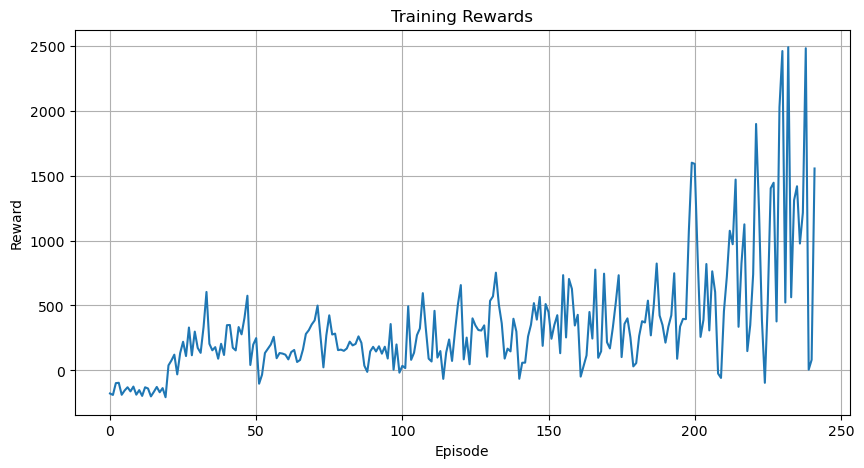

In [7]:
# Start training
# Set render=True to see the agent learning in real-time (Note: this may slow down training)
print(f"Starting BipedalWalker training on {device}...")

# Configurable Hyperparameters
MAX_EPISODES = 1000 # Can extend to 2000 if it doesn't converge
UPDATES_PER_STEP = 2  # Higher gradient updates per step for sample efficiency
NUM_ENVS = 4 # Number of parallel environments (vectorized)

rewards, trained_agent = train_agent(
    max_episodes=MAX_EPISODES, 
    device=device, 
    updates_per_step=UPDATES_PER_STEP,
    start_steps=10000,
    num_envs=NUM_ENVS,
    render=True  # Set to True to visualize training
) 
print("Training completed!")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title("Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

## Video Recording and Evaluation

After training, we can record a video of the agent's performance to visually verify its walking ability. This is required for the application.

In [ ]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import glob
import os

def record_video(agent, env_name="BipedalWalker-v3", filename="bipedal_walker", device="cpu"):
    # Create environment with render mode
    env = gym.make(env_name, render_mode="rgb_array")
    
    # Wrap environment to record video
    # We force record the first episode
    video_folder = "videos"
    os.makedirs(video_folder, exist_ok=True)
    env = RecordVideo(env, video_folder=video_folder, name_prefix=filename, episode_trigger=lambda x: True)
    
    state, _ = env.reset()
    done = False
    truncated = False
    total_reward = 0
    
    while not (done or truncated):
        # Use deterministic policy for evaluation
        action = agent.select_action(state, deterministic=True)
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward
    
    env.close()
    print(f"Evaluation Run - Total Reward: {total_reward:.2f}")
    
    # Find the video file
    mp4_files = glob.glob(f"{video_folder}/{filename}-episode-0.mp4")
    if mp4_files:
        print(f"Video saved to {mp4_files[0]}")
        return mp4_files[0]
    return None

# Record and display video
# Note: You need to have ffmpeg installed for this to work
if 'trained_agent' in locals():
    video_path = record_video(trained_agent, device=device)
    if video_path:
        display(Video(video_path, embed=True, html_attributes="controls autoplay loop"))

: 

In [ ]:
def run_ablation_study(device="cpu"):
    # Compare different learning rates
    learning_rates = [1e-3, 3e-4, 1e-4]
    results = {}
    
    print("Starting Ablation Study on Learning Rates...")
    
    # Create a timestamped directory for the ablation study
    study_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    study_dir = os.path.join("logs", f"ablation_{study_timestamp}")
    os.makedirs(study_dir, exist_ok=True)
    print(f"Ablation results will be saved to: {study_dir}")
    
    for lr in learning_rates:
        print(f"\nTesting Learning Rate: {lr}")
        # Run training for fewer episodes for ablation study to save time, or full duration if desired
        # Using 500 episodes for ablation study demonstration
        ablation_episodes = 500 
        
        # Use a separate subfolder for each learning rate to avoid file conflicts
        # and to keep logs organized
        run_log_dir = os.path.join(study_dir, f"lr_{lr}")
        
        rewards, _ = train_agent(max_episodes=ablation_episodes, device=device, learning_rate=lr, log_dir=run_log_dir)
        results[f"lr_{lr}"] = rewards
        
        # Save intermediate result in the study directory
        np.save(os.path.join(study_dir, f"ablation_rewards_lr_{lr}.npy"), rewards)
    
    print("Ablation study completed. Plotting results...")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    for name, rewards in results.items():
        # Smooth rewards for better visualization
        window = 10
        smoothed_rewards = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
        plt.plot(smoothed_rewards, label=name)
        
    plt.title("Ablation Study: Learning Rates (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the ablation study
run_ablation_study(device=device)

# AISF Application Writeup

## Applicant Information
- **Name**: [Your Name]
- **Email**: [Your Email]

## Prior Experience
*Briefly describe any prior experience you have in RL, Deep Learning, and coding.*

## Time Breakdown
*Total hours spent: X hours*
- Research/Reading: X hours
- Coding: X hours
- Training/Tuning: X hours
- Writing: X hours

## Compute Resources
*Describe the hardware used.*
- CPU: [Number of threads, Model]
- GPU: [Model] (if applicable)

## Techniques Used
*List the techniques used (e.g., SAC, Double Q-Learning, Soft Updates) and justify why they are suitable for this environment.*

## Ablation Studies
*Summarize the results of your ablation studies here. What hyperparameters did you tweak? What was the impact?*

## Discussion of Issues
*Discuss challenges encountered, ideas that didn't work, and how you pivoted.*

## Conclusion
*Summarize what worked well and what could be improved with more time.*

## Citations
- [Haarnoja, T., et al. "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." arXiv preprint arXiv:1801.01290 (2018).](https://arxiv.org/abs/1801.01290)
- [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/)